# Instala dependências

In [1]:
%pip install graphviz
%pip install pydotplus

You should consider upgrading via the '/home/igor/Desktop/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/home/igor/Desktop/UFES/6 Período-EART/Data Science/TP/datascience_env/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#basics
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#text process
import nltk
import unidecode
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Classification
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Decision tree
import graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier,export_graphviz




# Processamento dos dados

Como existem dados textuais podemos usar as funções já utilizadas no trabalho anterior




In [3]:
with open('./data/dataset.csv', encoding="utf8") as file:
    df = pd.read_csv(file)
    
df.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,0
1,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
2,2,NaN,NaN,"Heard about #earthquake is different cities, s...",0
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
4,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1


In [4]:
df.text = [c.lower() for c in df.text]

## Separação treino e teste

Ocorre a separação do dataset em treino em teste na proporção 80% pra 20%, respectivamente, além disso, a criação dos mesmo é feito de forma aleatória para não criarmos dataset enviesados, além de estar estratificado com o dataset.

In [5]:
from sklearn.model_selection import train_test_split

df_train_raw, df_test_raw = train_test_split(df, test_size=0.2, shuffle=True, random_state=42, stratify=df['target'])

df_train_raw = df_train_raw.sort_values(by=['id']).reset_index(drop=True)
df_test_raw = df_test_raw.sort_values(by=['id']).reset_index(drop=True)

df_train_raw = df_train_raw

# Trainset

In [6]:
print(df_train_raw.shape)
df_train_raw.head()

(8700, 5)


,id,keyword,location,text,target
0,0,NaN,NaN,just happened a terrible car crash,0
1,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1
2,2,NaN,NaN,"heard about #earthquake is different cities, s...",0
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0
4,4,NaN,NaN,forest fire near la ronge sask. canada,1


[Text(0, 0, 'Non Desaster'), Text(1, 0, 'Desaster')]

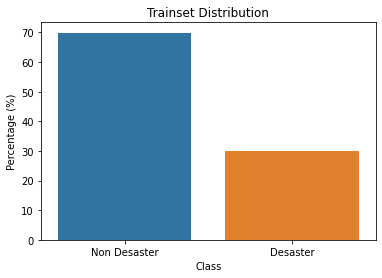

In [7]:
ax = sns.barplot(x='target', y='target',data = df_train_raw, estimator=lambda  x: len(x)/len(df_train_raw)*100)

ax.set_title('Trainset Distribution')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Class')
ax.set_xticklabels(["Non Desaster","Desaster"])

# Testset

In [8]:
print(df_test_raw.shape)
df_test_raw.head()

(2176, 5)


,id,keyword,location,text,target
0,9,NaN,NaN,apocalypse lighting. #spokane #wildfires,0
1,11,NaN,NaN,typhoon soudelor kills 28 in china and taiwan,0
2,12,NaN,NaN,we're shaking...it's an earthquake,0
3,24,NaN,NaN,i love fruits,0
4,31,NaN,NaN,this is ridiculous....,0


[Text(0, 0, 'Non Desaster'), Text(1, 0, 'Desaster')]

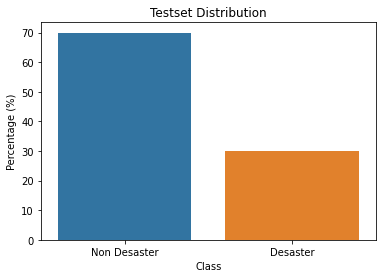

In [9]:
ax = sns.barplot(x='target', y='target',data = df_test_raw, estimator=lambda  x: len(x)/len(df_test_raw)*100)

ax.set_title('Testset Distribution')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Class')
ax.set_xticklabels(["Non Desaster","Desaster"])

## O impacto dos Hashtags nos tweets

In [10]:
def findHashtags(text: str):
    return [tag.strip("#") for tag in text.split() if tag.startswith("#")]

df_train_raw['hashtags'] = df_train_raw.text.copy()
df_train_raw['hashtags'] = df_train_raw['hashtags'].apply(findHashtags)

df_test_raw['hashtags'] = df_test_raw.text.copy()
df_test_raw['hashtags'] = df_test_raw['hashtags'].apply(findHashtags)

## Estudo da distribuição dos hashtags

In [11]:
hashtags_train = set()
for i in df_train_raw.hashtags:
    for j in i:
        hashtags_train.add(j)
hashtags_test=set()
for i in df_train_raw.hashtags:
    for j in i:
        hashtags_test.add(j)

### Find ocorrences of trainset

In [12]:
m={}
for i in range(df_train_raw.shape[0]):
    for j in df_train_raw.hashtags[i]:
        if df_train_raw['target'][i]:
            if(j not in m):
                m[j]=df_train_raw['target'][i]
            else:
                m[j]+=df_train_raw['target'][i]

# Sort the freq dict
freq_hashtags = {k: v for k, v in reversed(sorted(m.items(), key=lambda item: item[1]))}
print(freq_hashtags)

{'news': 42, '???': 18, 'hiroshima': 18, '??': 16, 'earthquake': 16, 'best': 10, 'prebreak': 10, 'hot': 10, 'japan': 10, 'india': 9, 'sismo': 8, 'world': 8, 'terrorism': 7, 'islam': 7, 'abstorm': 7, 'worldnews': 7, 'fukushima': 6, 'wx': 6, 'yyc': 6, 'rohingya': 6, 'wildfire': 6, 'isis': 5, 'bestnaijamade:': 5, 'nuclear': 5, 'africa': 5, 'okwx': 5, 'sittwe': 5, 'myanmar': 5, 'cnn': 5, 'breaking': 5, 'wildfires': 5, 'photography': 4, 'japì_n': 4, 'somalia': 4, 'sandiego': 4, 'bbc': 4, 'libya': 4, 'hostages': 4, 'hailstorm': 4, 'phoenix': 4, 'wmata': 4, 'mh370': 4, '\x89û_': 4, 'science': 3, 'idfire': 3, 'thunderstorm': 3, 'usnwsgov': 3, 'lies': 3, 'quran': 3, 'god': 3, 'truth': 3, 'gabon': 3, 'nytimes': 3, 'antioch': 3, 'guillermo': 3, 'hurricane': 3, 'bjp': 3, 'tdp': 3, 'trs': 3, 'nri': 3, 'ts': 3, 'ap': 3, 'iran': 3, 'boston': 3, 'arwx': 3, 'pakistan': 3, 'socialnews': 3, 'casper': 3, 'atlanta': 3, 'miami': 3, 'koin6news': 3, 'solar': 3, 'emergency': 3, 'drought': 3, 'genocide;': 3, 's

### Create a feature based in the hashtags

This feature will be 0 if any of the hashtags in the tweet has relevance to a disaster tweet, and will have a value greate than 0 if it has.

In [13]:
df_train_raw['mean_hashtags_target'] = [0,] * df_train_raw.shape[0]
df_test_raw['mean_hashtags_target'] = [0,] * df_test_raw.shape[0]

df_train_raw.head()

,id,keyword,location,text,target,hashtags,mean_hashtags_target
0,0,NaN,NaN,just happened a terrible car crash,0,[],0
1,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,[earthquake],0
2,2,NaN,NaN,"heard about #earthquake is different cities, s...",0,[earthquake],0
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0,[],0
4,4,NaN,NaN,forest fire near la ronge sask. canada,1,[],0


In [14]:
def computeMeanHashtags(df_func):
    aux = np.zeros(df_func.shape[0])
    for i in range(df_func.shape[0]):
        for j in df_func.hashtags[i]:
            if j in m:
                aux[i] += m[j]
        if len(df_func.hashtags[i]) != 0:
            aux[i] /= len(df_func.hashtags[i])
    df_func['mean_hashtags_target'] = aux

computeMeanHashtags(df_train_raw)
computeMeanHashtags(df_test_raw)
df_train_raw.head(15)

,id,keyword,location,text,target,hashtags,mean_hashtags_target
0,0,NaN,NaN,just happened a terrible car crash,0,[],0.000000
1,1,NaN,NaN,our deeds are the reason of this #earthquake m...,1,[earthquake],16.000000
2,2,NaN,NaN,"heard about #earthquake is different cities, s...",0,[earthquake],16.000000
3,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",0,[],0.000000
4,4,NaN,NaN,forest fire near la ronge sask. canada,1,[],0.000000
5,5,NaN,NaN,all residents asked to 'shelter in place' are ...,1,[],0.000000
6,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires],5.000000
7,7,NaN,NaN,just got sent this photo from ruby #alaska as ...,1,"[alaska, wildfires]",3.000000
8,8,NaN,NaN,#rockyfire update => california hwy. 20 closed...,1,"[rockyfire, cafire, wildfires]",3.333333
9,10,NaN,NaN,#flood #disaster heavy rain causes flash flood...,1,"[flood, disaster]",2.500000


## Limpeza dos textos dos tweets

Um coisa interessante de se pensar é que os dados textuais se dão através de textos escritos por pessoas em sua rede social tweeter e podem existir erros de digitação assim é importante tentar corrigir as palavras mal escritas. Para isso podemos usar a biblioteca spell checker.

In [15]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /home/igor/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/igor/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/igor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/igor/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

Reutilizando funções do trabalho prático

In [16]:
def remove_specials(tokens):
    return [unidecode.unidecode(word) for word in tokens]

def remove_punctuation(tokens):
    table = str.maketrans("","",string.punctuation)
    return [w.translate(table) for w in tokens]

def array_lower(tokens):
    return [w.lower() for w in tokens]

def remove_no_words(tokens):
    return [word for word in tokens if word.isalpha()]

def remove_stop_words(tokens):
    stop_words = set(stopwords.words('english'))
    return [w for w in tokens if not w in stop_words]


def text_cleaner(string):
   
    # Dividindo texto em tokens
    string = word_tokenize(string)
    #df_text_column = df_text_column.apply(word_tokenize)
    
    # Convertendo texto para minusculo
    string = array_lower(string)
    #df_text_column = df_text_column.apply(array_lower)

    # Removendo pontuação
    string = remove_punctuation(string)
    #df_text_column = df_text_column.apply(remove_punctuation)
    
    # Removendo caracteres especiais
    string = remove_specials(string)
    #df_text_column = df_text_column.apply(remove_specials)

    # Removendo tokens que não sao palavras
    string = remove_no_words(string)
    #df_text_column = df_text_column.apply(remove_no_words)

    # Removendo tokens que são stop words
    string = remove_stop_words(string)
    #df_text_column = df_text_column.apply(remove_stop_words)
    
    return string

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

#do_nothing = lambda x: x
N_COMPONENTS = 1000 #Vimos com o PCA diminuindo metade das featues tinha uma variancia explicada alta

wordnet_lemmatizer = WordNetLemmatizer()
lemmazation = lambda words: [wordnet_lemmatizer.lemmatize(tk) for tk in words]


tfidf = TfidfVectorizer(tokenizer = lemmazation,lowercase=False, preprocessor=text_cleaner, ngram_range=(1, 2),min_df=10,max_df=0.95)

text_process_pipe = Pipeline([
                             ("tfidf",tfidf),
                             ("pca", TruncatedSVD(n_components=N_COMPONENTS))
                             ])


In [26]:
X_train = text_process_pipe.fit_transform(df_train_raw['text'])
X_train = np.c_[X_train, df_train_raw['mean_hashtags_target']]
y_train = df_train_raw['target']

In [27]:
X_test = text_process_pipe.transform(df_test_raw['text'])
X_test = np.c_[X_test, df_test_raw['mean_hashtags_target']]
y_test = df_test_raw['target']

In [28]:
print(f"Total variance explained: {text_process_pipe['pca'].explained_variance_ratio_.sum()*100:.2f}%")

Total variance explained: 89.70%


In [29]:
X_test.shape

(2176, 1001)

In [30]:
#Transforma as features em um Dataframe
X_train_view = pd.DataFrame(data=X_train, columns=list(range(N_COMPONENTS+1)))
X_train_view.head()

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,0.027390,0.023885,0.002445,0.018445,0.009594,0.002068,0.011590,0.017634,-0.020170,-0.002026,...,-0.049433,0.011218,0.066318,-0.010749,0.056182,-0.009914,-0.063031,-0.021313,0.038802,0.0
1,0.058015,0.073551,0.002264,0.034069,-0.019070,-0.016366,-0.122013,-0.038034,-0.083589,-0.011414,...,-0.004222,0.008489,0.001604,-0.000445,0.002026,-0.016980,0.003448,-0.002803,-0.010347,16.0
2,0.024883,0.030207,0.006758,0.017866,-0.003076,-0.001520,-0.010395,-0.001100,-0.018970,0.014374,...,0.014197,0.007133,-0.020103,-0.010094,0.006768,-0.017572,-0.005259,-0.009157,-0.016668,16.0
3,0.048726,0.081890,0.290809,-0.111864,-0.012933,0.017584,-0.046219,-0.055971,0.054276,-0.128583,...,-0.007496,-0.030305,0.003464,-0.023382,-0.016220,0.007546,0.034382,0.014674,-0.010582,0.0
4,0.051356,0.079290,0.313697,-0.122393,-0.017218,0.021091,-0.070963,-0.055790,0.075077,-0.147688,...,-0.001621,0.043934,-0.026444,0.002594,0.045690,0.006993,-0.012084,0.023583,0.003572,0.0


Text(0, 0.5, 'Variancia explicada')

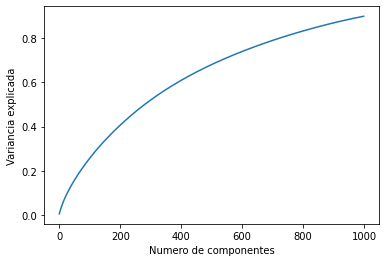

In [31]:
plt.plot(np.cumsum(text_process_pipe['pca'].explained_variance_ratio_))
plt.xlabel('Numero de componentes')
plt.ylabel('Variancia explicada')

# Analise exploratória de cada classe

Os dados possuem 2 classes são elas:

0 - Tweets sobre desastres que são fake (Não Desastre)

1 - Tweets sobre desastres que são reais (Desastre)

[Text(0, 0, 'Não Desastre'), Text(1, 0, 'Desastre')]

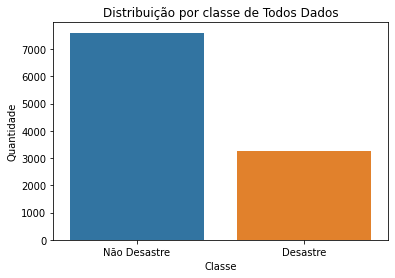

In [32]:
ax = sns.countplot(x='target',data = df)

ax.set_title('Distribuição por classe de Todos Dados')
ax.set_ylabel('Quantidade')
ax.set_xlabel('Classe')
ax.set_xticklabels(["Não Desastre","Desastre"])

Podemos comparar algumas caracteristicas do texto, como tamanho do texto e a quantidade de tokens geradas por cada.

Text(0.5, 1.05, 'Distribuição da quantidade de caracteres do tweet por classe')

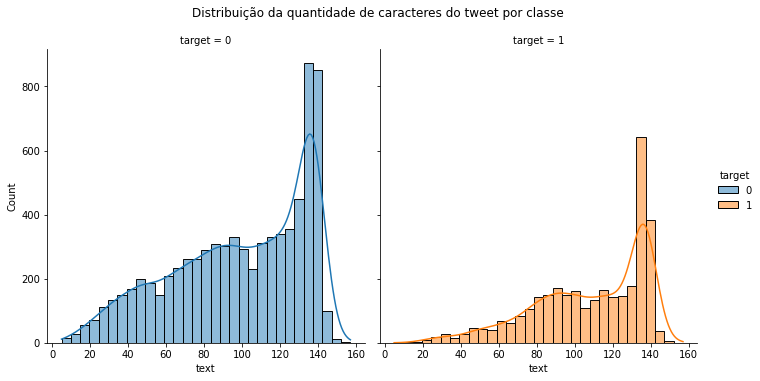

In [33]:
ax = sns.displot(x=df['text'].str.len(),data = df,col='target',hue='target',kde=True)

ax.fig.suptitle('Distribuição da quantidade de caracteres do tweet por classe',y=1.05)

# Classificadores

In [34]:
def test_classifier(classifier,params,X_train,y_train,X_test,y_test):
    params = params
    clf = GridSearchCV(classifier, params, n_jobs = -1,cv=5)
    clf.fit(X_train, y_train)
    
    print(clf.best_params_)
    
    y_predicted = clf.predict(X_test)
    
    print(classification_report(y_test, y_predicted))
    ConfusionMatrixDisplay.from_predictions(y_test, y_predicted);
    
    return clf

## Knn

{'n_neighbors': 13}
              precision    recall  f1-score   support

           0       0.74      0.93      0.83      1522
           1       0.61      0.24      0.35       654

    accuracy                           0.73      2176
   macro avg       0.68      0.59      0.59      2176
weighted avg       0.70      0.73      0.68      2176



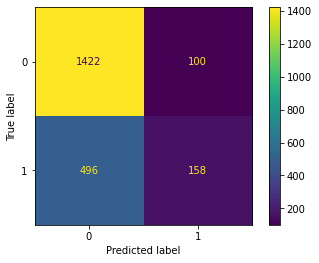

In [35]:
params = {'n_neighbors': [3,5,7,11,13]}

knn = test_classifier(KNeighborsClassifier(),params,X_train,y_train,X_test,y_test)

## Decision Tree

{'criterion': 'gini', 'max_depth': 4}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82      1522
           1       0.57      0.20      0.30       654

    accuracy                           0.71      2176
   macro avg       0.65      0.57      0.56      2176
weighted avg       0.68      0.71      0.66      2176



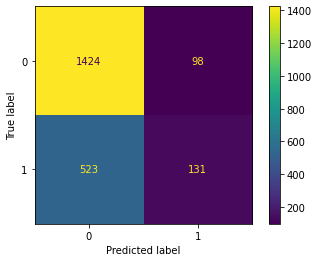

In [36]:
params = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}

dt = test_classifier(DecisionTreeClassifier(),params,X_train,y_train,X_test,y_test)

In [37]:
dot_data = export_graphviz(dt.best_estimator_, out_file=None,
                     filled=True, rounded=True,  
                     special_characters=True)

graph = graphviz.Source(dot_data)  
#graph.render("dt-vis",view = True)
#graph

## Random Forest

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
#
# params = {'bootstrap': [True, False],
#           'max_depth': [10, 20, 30, None],
#           'max_features': ['auto', 'sqrt']}
#
#
# rf = test_classifier(RandomForestClassifier(),params,X_train,y_train,X_test,y_test)

KeyboardInterrupt: 